In [1]:
# import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from alstm import ALSTMModel
from nltk.corpus import stopwords
from text_preprocessor import TextPreprocessor
from training import train_model, evaluate_model, cross_validate
from preprocess import collate_fn, read_dataset, log_model_train_scenario, plot_model_history, log_report_and_conf_mat,log_model_history, TextClassificationDataset
import os
import time
import numpy as np
from torch.utils.data import ConcatDataset

[nltk_data] Downloading package punkt to /Users/mfshobur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mfshobur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mfshobur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def create_new_data(use_stopwords, use_stemming, use_lemma, cross_validation=False):
    """
    Return train, validation, test loader, and text preprocessor
    """
    train_df = read_dataset('../dataset/trec_train.csv')
    train_df = train_df.dropna()
    test_df = read_dataset('../dataset/trec_test.csv')
    test_df = test_df.dropna()

    # drop all abbreviation
    drop_abbreviation=True
    if drop_abbreviation:
        train_df = train_df[train_df['coarse_label'] != 0]
        train_df['coarse_label'] = train_df['coarse_label'].apply(lambda x: x-1)
        test_df = test_df[test_df['coarse_label'] != 0]
        test_df['coarse_label'] = test_df['coarse_label'].apply(lambda x: x-1)
        label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]
    else:
        label_names = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]

    train_texts = train_df['text'].values
    test_texts = test_df['text'].values

    train_labels = train_df['coarse_label'].values
    test_labels = test_df['coarse_label'].values

    X_test = test_texts
    y_test = test_labels

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
    )

    # Preprocess text data
    # CONFIG
    stop = set(stopwords.words('english'))
    preprocessor = TextPreprocessor(stopwords=stop, max_vocab_size=10000, max_seq_length=50)
    trec_vocab = preprocessor.get_vocab_from_texts(
        [*X_test, *X_val, *X_train],
        use_stopwords=use_stopwords,
        use_lemmatization=use_lemma,
        use_stemming=use_stemming,
    )

    preprocessor.download_model(filter_from_vocab=trec_vocab, save_embedding=True)
    # preprocessor.fit([*X_train, *X_val, *X_test])
    print(f'Jumlah vocabulary/kosa kata: {preprocessor.vocab_size}')

    # Transform texts to sequences
    X_train_seq = preprocessor.transform(X_train, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)
    X_val_seq = preprocessor.transform(X_val, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)
    X_test_seq = preprocessor.transform(X_test, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)

    labels = len(label_names)
    labels_total = train_df['coarse_label'].value_counts().sort_index().values
    # imbalance dataset
    targets = []
    # targets += [[index] * labels_total[index] for index in range(labels)]
    for i in range(labels):
        targets += [i] * labels_total[i]

    # Create datasets
    train_dataset = TextClassificationDataset(X_train_seq, y_train)
    val_dataset = TextClassificationDataset(X_val_seq, y_val)
    test_dataset = TextClassificationDataset(X_test_seq, y_test)

    if cross_validation:
        labels = len(label_names)
        labels_total = train_df['coarse_label'].value_counts().sort_index().values
        # imbalance dataset
        targets = []
        # targets += [[index] * labels_total[index] for index in range(labels)]
        for i in range(labels):
            targets += [i] * labels_total[i]
        train_dataset = ConcatDataset([train_dataset, val_dataset])
        return train_dataset, None, test_dataset, preprocessor, targets

    batch_size=50
    num_workers=0

    torch.manual_seed(42)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        collate_fn=collate_fn)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate_fn)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader, preprocessor

In [ ]:
# Scenario
scenario = {
    'epoch': [20, 40, 60, 80, 100],
    'drop_rate': [0.0, 0.2, 0.4, 0.6,  0.8],
    'learning_rate': [0.1, 0.01, 0.001, 0.001,  0.0001, 0.00001],
    'weight_decay': [0.1, 0.01, 0.001,  0.0001],
    'vocabulary': [None, 'use_stopwords', 'use_stemming', 'use_lemma'],
    'n_heads': [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75, 150],
}

active_scenario = {
    'epoch': 20,
    'drop_rate': 0.5,
    'learning_rate': 0.001,
    'weight_decay': 0.01,
    'use_stopwords': False,
    'use_stemming': False,
    'use_lemma': False,
    'n_heads': 1
}

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]

Using device: cpu


In [4]:
def update_current_scenario_vocab(active_scenario: dict, current_value):
    if current_value is None:
        for key in active_scenario.keys():
            if 'use' in key:
                active_scenario[key] = False
    else:
        for key in active_scenario.keys():
            if 'use' in key:
                if key == current_value:
                    active_scenario[key] = True
                else:
                    active_scenario[key] = False
    return active_scenario

In [5]:
active_scenario

{'epoch': 20,
 'drop_rate': 0.5,
 'learning_rate': 0.001,
 'weight_decay': 0.01,
 'use_stopwords': False,
 'use_stemming': False,
 'use_lemma': False,
 'n_heads': 1}

Jumlah vocabulary/kosa kata: 8898
Scenario 1: epoch
1. {'epoch': 2, 'drop_rate': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.01, 'use_stopwords': False, 'use_stemming': False, 'use_lemma': False, 'n_heads': 1}
Starting training for scenario 1-epoch: 2
Total fold: 10
Fold: 1:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.6460270030316472

New model saved from fold 1

Fold: 2:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.8692689454755304

Fold: 3:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.7404704914190694

Fold: 4:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.7735209931208434

Fold: 5:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold bes

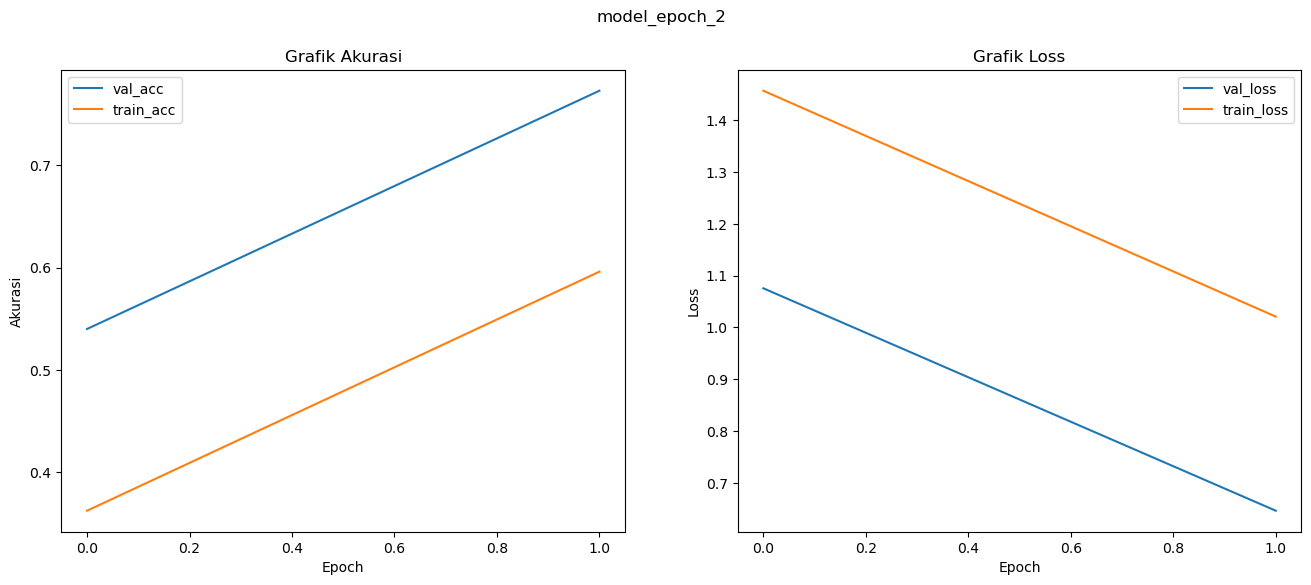

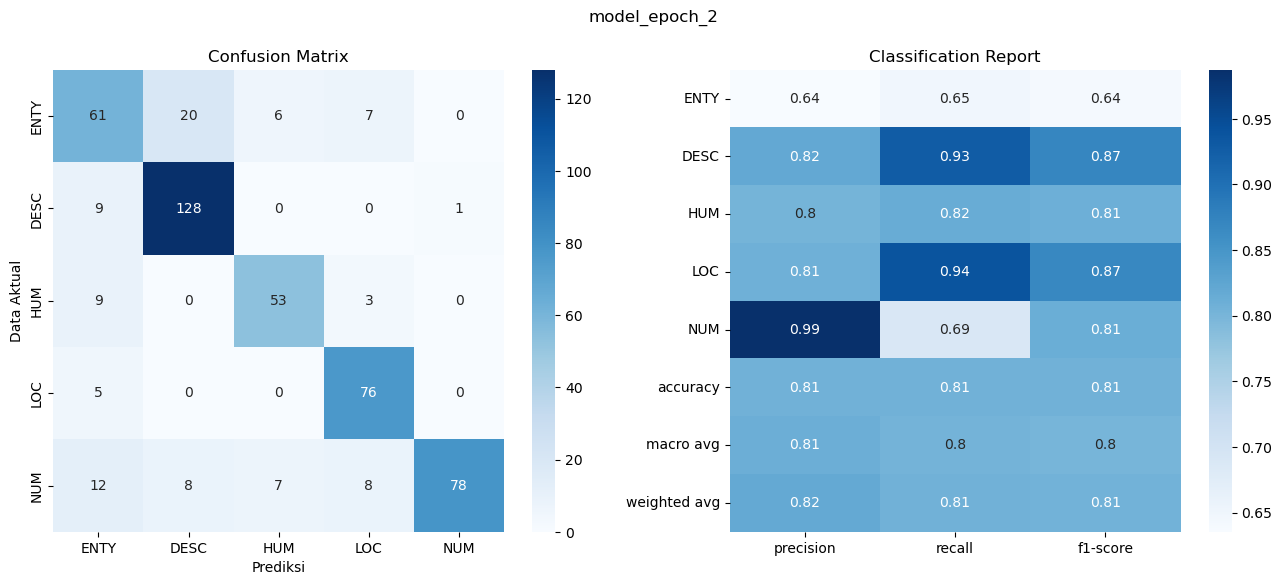

model logged
Training finished. Total time: 00:14

2. {'epoch': 2, 'drop_rate': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.01, 'use_stopwords': False, 'use_stemming': False, 'use_lemma': False, 'n_heads': 1}
Starting training for scenario 1-epoch: 2
Total fold: 10
Fold: 1:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.7404881755732957

New model saved from fold 1

Fold: 2:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.6978525435014366

New model saved from fold 2

Fold: 3:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.6685829586600902

New model saved from fold 3

Fold: 4:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.7128246872784705

Fold: 5:
Train class distribution: 8726
Validation class

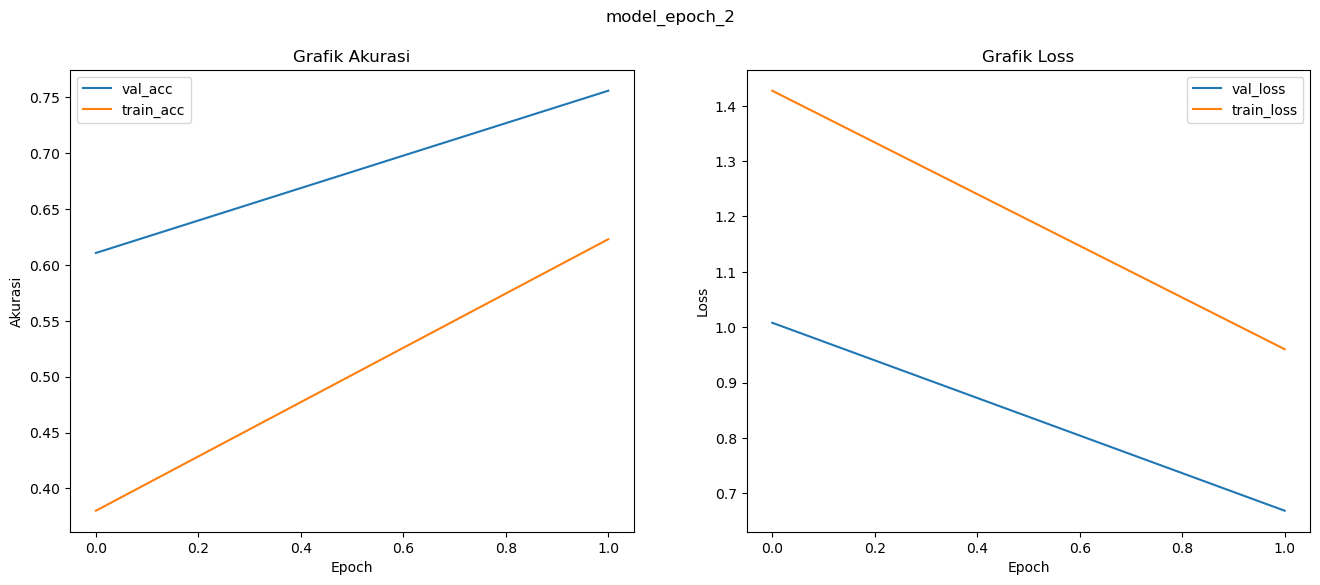

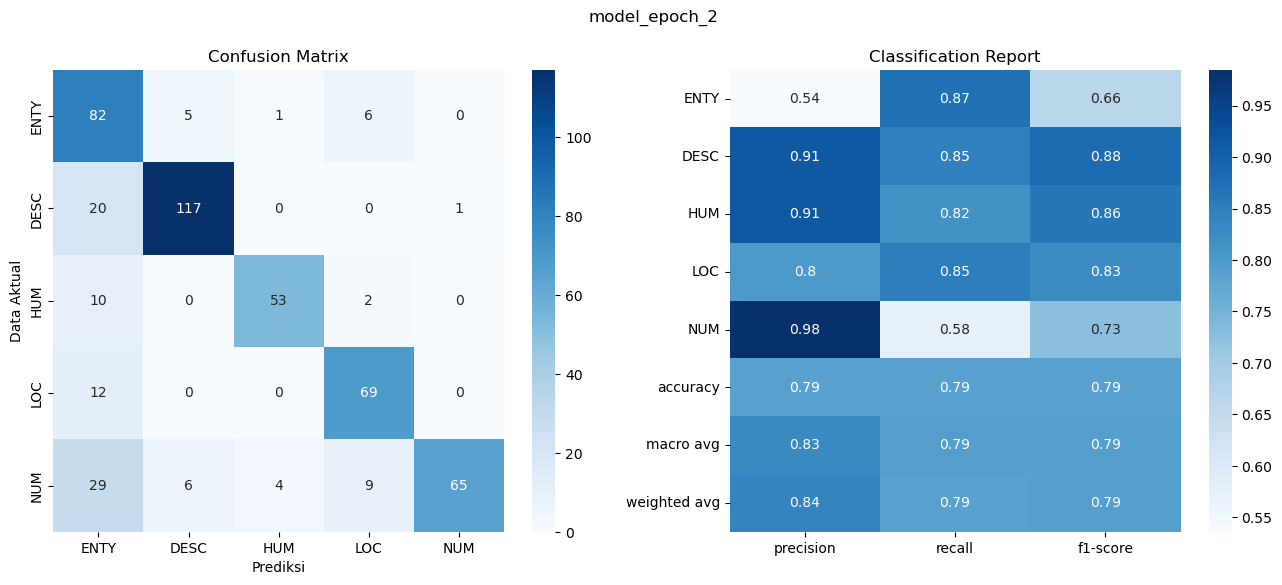

model logged
Training finished. Total time: 00:15

3. {'epoch': 2, 'drop_rate': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.01, 'use_stopwords': False, 'use_stemming': False, 'use_lemma': False, 'n_heads': 1}
Starting training for scenario 1-epoch: 2
Total fold: 10
Fold: 1:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.6837901142278419

New model saved from fold 1

Fold: 2:
Train class distribution: 8727
Validation class distribution: 970
copying embedding matrix
this fold best valid loss: 0.7897873570799162

Fold: 3:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.7508220553842114

Fold: 4:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best valid loss: 0.710563119119328

Fold: 5:
Train class distribution: 8726
Validation class distribution: 971
copying embedding matrix
this fold best 

KeyboardInterrupt: 

In [ ]:
use_cross_validation=True
k_fold=10

g = torch.Generator()
g.manual_seed(42)

train_loader, val_loader, test_loader, preprocessor, targets = create_new_data(
    use_stopwords=active_scenario['use_stopwords'],
    use_lemma=active_scenario['use_lemma'],
    use_stemming=active_scenario['use_stemming'],
    cross_validation=use_cross_validation
)
label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]

no = 0
folder = 'scenario'
csv_path = f'{folder}/scenario.csv'

if not os.path.exists(folder):
    os.mkdir(folder)

# run through all scenarios (keys)
for i, key in enumerate(scenario.keys()):
    scenario_num = i+1
    print(f'Scenario {scenario_num}: {key}')
    val_loss = []
    val_accs = []
    
    folder_path = f'{folder}/{scenario_num}'
    # create folder if not exist
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    # run all value inside the scenario
    for value in scenario[key]:
        model_name = f'model_{key}_{value}'
        model_folder = f'{folder_path}/{model_name}'
        # create folder if not exist
        if not os.path.exists(model_folder):
            os.mkdir(model_folder)

        no += 1
        if value is not None and key == 'vocabulary':
            active_scenario = update_current_scenario_vocab(active_scenario, value)
            train_loader, val_loader, test_loader, preprocessor = create_new_data(
                use_stopwords=active_scenario['use_stopwords'],
                use_lemma=active_scenario['use_lemma'],
                use_stemming=active_scenario['use_stemming'],
                use_cross_validation=use_cross_validation,
            )
            print('\nNew data generated')
        if key != 'vocabulary':
            active_scenario[key] = value

        # update the value for active scenario key
        print(f'{no}. {active_scenario}')
        
        # Initialize model
        cfg = {
            'drop_rate': active_scenario['drop_rate'],
            'output': 5,
            'bidirectional': True,
            'vocab_size': preprocessor.vocab_size,
            'context_length': 100,
            'emb_dim': 300,
            'hidden_size': 150,
            'qkv_bias': False,
            'n_heads': active_scenario['n_heads'],
            'device': device,
            'lstm_layers': 1,
        }
        
        criterion = nn.CrossEntropyLoss()

        start_train = time.time()

        print(f'Starting training for scenario {scenario_num}-{key}: {value}')

        # train model
        if not use_cross_validation:
            model = ALSTMModel(cfg)
            model.to(device)

            # copy embedding google-news-300
            model.embedding.weight.data.copy_(torch.from_numpy(preprocessor.embedding_matrix))
            # freeze layer embedding
            model.embedding.weight.requires_grad = False

            optimizer = optim.AdamW(model.parameters(), lr=active_scenario['learning_rate'], weight_decay=active_scenario['weight_decay'])
            history = train_model(
                model=model,
                train_loader=train_loader,
                valid_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                num_epochs=active_scenario['epoch'],
                log=False,
                best_model_path=f'{model_folder}/{model_name}.pt'
            )
        else:
            history, test_acc, test_loss, report, conf_mat, model = cross_validate(
                cfg=cfg,
                preprocessor=preprocessor,
                train_dataset=train_loader,
                test_dataset=test_loader,
                targets=targets,
                criterion=criterion,
                learning_rate=active_scenario['learning_rate'],
                weight_decay=active_scenario['weight_decay'],
                collate_fn=collate_fn,
                label_names=label_names,
                fold=k_fold,
                batch_size=50,
                num_epochs=active_scenario['epoch'],
                best_model_path=f'{model_folder}/{model_name}.pt',
                debug=False,
                device=device,
            )

        end_train = time.time()
        total_train = (end_train - start_train)
        if use_cross_validation:
            # mean of total train
            total_train = total_train / k_fold

        # change time format to MM:SS
        minutes, seconds = divmod(int(total_train), 60)
        formatted_time = f"{minutes:02d}:{seconds:02d}"


        # evaluate data on test dataset
        if not use_cross_validation:
            model.load_state_dict(torch.load(f'{model_folder}/{model_name}.pt', weights_only=True))
            model.to(device)
            test_loss, test_acc, report, conf_mat = evaluate_model(
                model=model,
                test_loader=test_loader,
                criterion=criterion,
                device=device,
                label_names=label_names,
                return_report=True
            )
            print(f"Test accuracy: {test_acc:.4f}")

        
        # save model's validation loss
        val_loss.append(test_loss)
        val_accs.append(test_acc)

        # simpan log training dan testing
        plot_model_history(
            history=history,
            title=model_name,
            save_path=f'{model_folder}/train_test_graph.png'
        )

        log_model_history(
            history,
            save_path=f'{model_folder}/train_valid_log.csv'
        )

        log_report_and_conf_mat(
            title=model_name,
            report=report,
            confusion_matrix=conf_mat,
            label_names=label_names,
            save_path=f'{model_folder}/classification_report_and_confusion_matrix.png'
        )
        
        log_model_train_scenario(
            scenario_num=scenario_num,
            scenario=key,
            epoch=active_scenario['epoch'],
            drop_rate=active_scenario['drop_rate'],
            learning_rate=active_scenario['learning_rate'],
            weight_decay=active_scenario['weight_decay'],
            vocabulary='use_stopwords' if active_scenario['use_stopwords'] else 'use_stemming' if active_scenario['use_stemming'] else 'use_lemma' if active_scenario['use_lemma'] else None,
            n_heads=active_scenario['n_heads'],
            vocabulary_total=preprocessor.vocab_size,
            train_acc=f"{history['train_accs'][-1]:.4f}",
            test_acc=test_acc,
            train_loss=f"{history['train_losses'][-1]:.4f}",
            test_loss=test_loss,
            time=formatted_time,
            file=csv_path,
        )

        print(f'Training finished. Total time: {formatted_time}\n')

        # hapus model dan optimizer untuk meringankan memori
        if not use_cross_validation:
            del model
            del optimizer

    # print(f"\nBest value from {key} is {scenario[key][np.argmin(val_loss)]}\n")
    print(f"\nBest value from {key} is {scenario[key][np.argmax(val_accs)]}\n")
    # create new data if previously process vocabulary scenario
    if key == 'vocabulary':
        # min_index = np.argmin(val_loss)
        # value = scenario[key][min_index]
        max_index = np.argmax(val_accs)
        value = scenario[key][max_index]
        active_scenario = update_current_scenario_vocab(active_scenario, value)
        train_loader, val_loader, test_loader, preprocessor = create_new_data(
            use_stopwords=active_scenario['use_stopwords'],
            use_lemma=active_scenario['use_lemma'],
            use_stemming=active_scenario['use_stemming'],
            use_cross_validation=use_cross_validation,
        )
        print('\nNew data generated')
    else:
        # check for the hyperparameter with least loss and set it as active scenario
        # min_index = np.argmin(val_loss)
        # active_scenario[key] = scenario[key][min_index]
        max_index = np.argmax(val_accs)
        value = scenario[key][max_index]